In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pyhf.readxml
from ipywidgets import interact, fixed
import pyhf

In [4]:
parsed = pyhf.readxml.parse('meas.xml',os.getcwd())

In [5]:
p = pyhf.hfpdf(parsed, poiname = 'SigXsecOverSM')
obsdata = p.spec['data']['channel1'] 
data = obsdata + p.config.auxdata

In [6]:
c = p.spec['channels'][0]
parnamedict = {k: v['slice'].start for k,v in p.config.par_map.items()}

In [58]:
def plot(ax = None, **parsettings):
    if ax is None:
        f,ax = plt.subplots(1,1)
        f.set_size_inches(10,5)
        ax.set_ylim(0,1.5*np.max(obsdata))
    pars = pyhf.tensorlib.astensor(p.config.suggested_init())
    for k,v in parsettings.items():
        pars[parnamedict[k]] = v
    mccounts = [p.expected_sample(c,s, pars) for s in c['samples']]
    bottom = None
    for i,bardata in enumerate(mccounts):
        x = np.arange(len(bardata))
        p1 = ax.bar(x, bardata, 1, bottom = bottom, alpha = 1.0)
        bottom = bardata if i==0 else bottom + bardata
    ax.scatter(x,obsdata, c = 'k', alpha = 1., zorder=99)

In [72]:
interact(plot, ax = fixed(None), **{n[0]: tuple(m) for n,m in zip(sorted(reversed(list(parnamedict.items())), key=lambda x:x[1]), p.config.suggested_bounds())})

interactive(children=(IntSlider(value=5, description='SigXsecOverSM', max=10), IntSlider(value=0, description=…

<function __main__.plot(ax=None, **parsettings)>

In [32]:
nominal = p.config.suggested_init()
bestfit = pyhf.optimizer.unconstrained_bestfit(pyhf.loglambdav, data, p, p.config.suggested_init(), p.config.suggested_bounds())

/Users/lukas/Code/pyhf/pyhf/tensor/numpy_backend.py:96: RuntimeWarning: invalid value encountered in log
  return np.exp(n*np.log(lam)-lam-gammaln(n+1.))


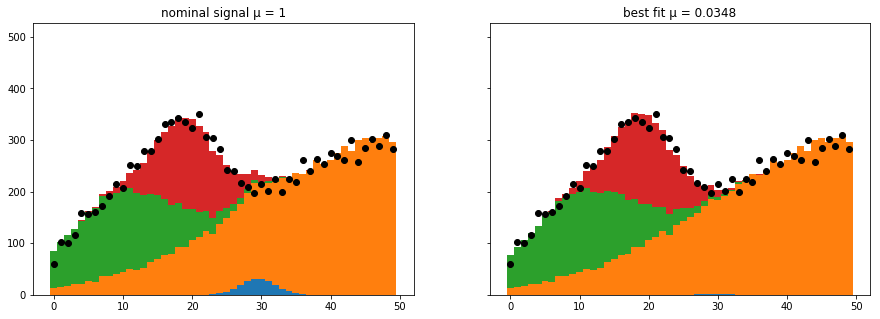

In [69]:
f,(ax1,ax2) = plt.subplots(1,2, sharey = True, sharex = True)
f.set_size_inches(15,5)
ax1.set_ylim(0,1.5*np.max(obsdata))
ax1.set_title('nominal signal µ = 1')
plot(ax = ax1, **{k: nominal[v] for k,v in parnamedict.items()})

ax2.set_title('best fit µ = {:.3g}'.format(bestfit[p.config.poi_index]))
plot(ax = ax2, **{k: bestfit[v] for k,v in parnamedict.items()})

In [51]:
def plot_results(testmus, cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests, cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def CLsOnePoint(muTest, data, pdf, init_pars, par_bounds):
    clsobs, cls_exp = pyhf.runOnePoint(muTest, data, pdf, init_pars,par_bounds)[-2:]
    return 1./clsobs, [1./x for x in cls_exp]

def invert_interval(testmus, cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = cls_exp_sigma
        point05cross['exp'].append(np.interp(test_size, list(reversed(yvals)), list(reversed(testmus))))
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size, list(reversed(yvals)), list(reversed(testmus)))
    return point05cross

/Users/lukas/Code/pyhf/pyhf/tensor/numpy_backend.py:96: RuntimeWarning: invalid value encountered in log
  return np.exp(n*np.log(lam)-lam-gammaln(n+1.))


{'exp': [0.24328880595266367,
  0.3278591824843914,
  0.4532264154327291,
  0.6357816732579623,
  0.8572766878609952],
 'obs': 0.47928976983278127}

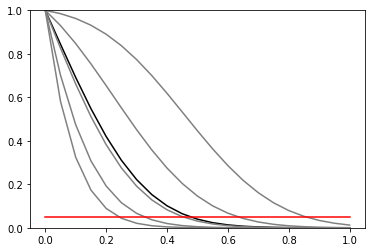

In [52]:
mutests = np.linspace(0,1,21)
hypotests = [CLsOnePoint(mu, data, p, p.config.suggested_init(), p.config.suggested_bounds()) for mu in mutests]

cls_obs = np.array([test[0] for test in hypotests]).flatten()
cls_exp = [np.array([test[1][i] for test in hypotests]).flatten() for i in range(5)]
plot_results(mutests, cls_obs, cls_exp)
invert_interval(mutests, cls_obs, cls_exp)

In [70]:
interact?